## Linear mixed models

Linear models start simple: they assumed that a trait $Y$ can be explained entirely by a fixed relationship to a set of predictors, along with some residual error.

$$ Y = X \beta + \epsilon $$

Linear mixed models account for known variation in linear models. They do this by quantifying the variation caused by *fixed effects* and *random effects*.

$$\begin{equation} Y = X \beta + Zu + \epsilon \end{equation}$$

The $X\beta$ corresponds to the *fixed effect*, and the $Zu + \epsilon$ corresponds to the *random effect*.

There is good reason to believe this formulating a phenotype into this relationship is useful, especially when we know that there exists distinct groups within our set of predictors.

$u$ here can be thought of as a fixed value, similar to $\beta$. However, it is more commonly described as a random variable.

$$u \sim N(0,D)$$

An important point to notice, is that $u$ has mean $0$. All the fixed effects are captured in the $X\beta$ term. It is therefore important to include any group fixed effects into the $X$ matrix.

To make this clear, let us assume that trait $Y$ is modelled as the sum of a fixed and random effect, as before. Let us in addition assume that the group membership of a specific data point causes a a fixed effect on the mean. 


$$ Y = X\beta + Z\gamma + Zu $$

$\gamma$ is a vector of coefficients which quantifies the fixed effect of being in a specific group. The information that encodes which group a certain data point came from, is given by the design matrix $Z$.

This can be formulated in the following way:


$$ Y = \begin{pmatrix}X & Z\end{pmatrix} \begin{pmatrix}\beta \\ \gamma\end{pmatrix} + Zu$$

i.e. 

$$ Y = X^*\beta^* + Zu$$

For some other $X^*$ and $\beta^*$. This is the same formulation as before, if we remember to include group membership in our set of predictors.


Since $u$ is a random variable, we don't actually estimate it. We estimate the variance covariance matrix $D$.

Finally, we need to estimate the residual term, $\epsilon$.
 
$$\epsilon \sim N(0,R) $$

In our specific case, we want to quantify the variation of our image features outside of known technical factors. As such, we treat these factors as **fixed effects**. Fixed-effects are commonly used to capture the effect of being in a group, whereas random effect capture the effect of repeated trials from a single individual. Right now, we do not have any repeated measures, so we do not include random effects.

LMM are already included in limix - a package developed by the Stegle group at the EBI which implements well known models from statistical genetics. Specifically, it is included as `limix.qtl.qtl_test_lmm`. This function takes in as parameters the snps matrix and phenotype vector, as well as optional parameters specifying the covariance structure of the data that we want to include as fixed effects. In our data, we have a matrix of gene expression values, but this can be inputted into limix without a problem. 

In [ ]:
Re

## Plan

We want to choose the best way to account for this technical variation. How do we do this? First we choose two methods:
- Include our 4 known technical factors as fixed effects.
- Include the first 5 PCs as fixed effects.

How do we decide which is the best method? We'll do this by measuring the inflation parameter $\lambda$. This parameter is defined as the median of of the distribution of the raw test statistics, and the median of a $\chi^2$ distribution with 1 degree of freedom. The closer this number is to 1, the more technical variation has been removed from the model.

## Specifying the technical covariates

To specify the technical covariates, we mine the phenotype data.

In [35]:
import pickle
import pandas as pd
import gzip
phenotype_filepath = '/nfs/research2/stegle/stegle_secure/GTEx/download/49139/PhenoGenotypeFiles/RootStudyConsentSet_phs000424.GTEx.v6.p1.c1.GRU/PhenotypeFiles/phs000424.v6.pht002743.v6.p1.c1.GTEx_Sample_Attributes.GRU.txt.gz'
with gzip.open(phenotype_filepath, 'rb') as f:
    phenotype_array = [str(x, 'utf-8').split('\t') for x in f.read().splitlines() if not str(x, 'utf-8').startswith('#')][1:]
    phenotype_df = pd.DataFrame(phenotype_array)
    phenotype_df.columns = phenotype_df.iloc[0]
    phenotype_df = phenotype_df[1:]

# import pandas as pd
# df = pickle.load(open(GTEx_directory + '/data/phenotype_pandas_dataframe.py','rb'))

lung_df = phenotype_df[phenotype_df['SMTSD'] == 'Lung']
phenotype_idx = [[x.split('-')[1] for x in lung_df['SAMPID']].index(ID) for ID in [x.decode('utf-8').split('-')[1] for x in donor_IDs]]

SMTSISCH = np.log(np.array(lung_df['SMTSISCH']).astype(np.float32))
SMTSISCH = SMTSISCH[phenotype_idx]
SMRIN = np.array([float(x) if x != '' else 0 for x in np.array(lung_df['SMRIN']) ])
SMRIN = SMRIN[phenotype_idx]
SMEXNCRT = np.array([float(x) if x != '' else 0 for x in np.array(lung_df['SMEXNCRT']) ])
SMEXNCRT = SMEXNCRT[phenotype_idx]
SMNTRNRT = np.array([float(x) if x != '' else 0 for x in np.array(lung_df['SMNTRNRT']) ])
SMNTRNRT = SMNTRNRT[phenotype_idx]
raw_technical_covariates = np.array([SMTSISCH,SMRIN,SMEXNCRT,SMNTRNRT]).T

In [206]:
technical_idx = np.sum(raw_technical_covariates > 0, axis=1) == 4

These acronyms, SMTSISCH, SMRIN, SMEXNCRT, and SMNTRNRT mean:
- Time between tissue death and harvesting
- RIN number (RNA degradation)
- Exon mapping number
- Intro mapping number

Respectively. They can directly be added into lmm as covariates.

Now we load in all the precomputed features

In [1]:
import os
import sys
sys.path = ['/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages'] + sys.path
GTEx_directory = '/hps/nobackup/research/stegle/users/willj/GTEx'
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import h5py
from scipy.stats import pearsonr
import statsmodels.stats.multitest as smm
import seaborn
import pickle
import pandas

import h5py
mean_features = {}
with h5py.File(GTEx_directory + '/data/intermediate/new_retrained_inceptionet_aggregations.hdf5','r') as f:
    expression = f['lung']['256']['expression'].value
    donor_IDs = f['lung']['256']['donor_IDs'].value
    for s in ['128','256','512','1024','2048']:
        size_mean_features = f['lung'][s]['mean'].value
        mean_features[s] = size_mean_features
        
        
    expression_IDs = f['lung']['256']['expression_IDs'].value

most_expressed_transcript_idx, most_varying_feature_idx, results = pickle.load(open(GTEx_directory + '/data/intermediate/retrained_quick_pvalues.py','rb'))

filt_expression = expression[:,most_expressed_transcript_idx]
filt_features = expression[:,most_varying_feature_idx]

We take the top 100 most variable image features, along with the top 100 transcripts with highest mean expression and the 100 transcript with the highest variance

In [207]:
print ("Raw features:")
print (mean_features['256'].shape, expression.shape)
print ("Filtered features:")
print (filt_expression.shape, filt_features.shape)

Raw features:
(274, 1024) (274, 28683)
Filtered features:
(274, 200) (274, 100)


We then take the indexes for which we have technical covariate data. Technical factors for which there is missing data are given the value 0 - however this is treated as a 0 value in the analysis, and causes a problem. 231 out of 274 of the samples have all of the technical factor information.

In [211]:
filt_tech_expression =  filt_expression[technical_idx,:]
filt_tech_features =  filt_features[technical_idx,:]
print ("Filtered technical features:")
print (filt_tech_expression.shape, filt_tech_features.shape)

Filtered technical features:
(231, 200) (231, 100)


In [212]:
from limix.qtl import qtl_test_lmm
feature = 0
single_feature = filt_features[:,feature].copy()
res = qtl_test_lmm(single_feature, filt_expression.astype(float))

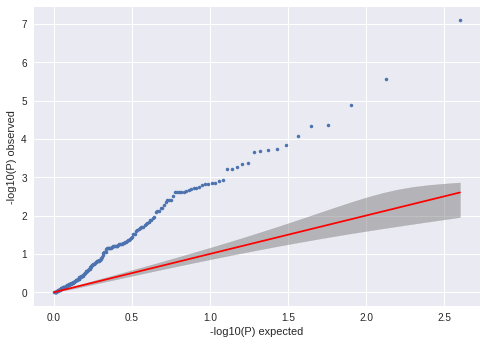

In [213]:
from limix.plot import qqplot
lim_pvalues = res.getPv().flatten()
qqplot(lim_pvalues)

Even using lim, we see that our p-values are less inflated. Indeed, we can look at our $\lambda$ statistic.

In [214]:
estimate_lambda(lim_pvalues)

4.9437715861936482

This $\lambda$ statistics is still extremely high. Most papers report a $\lambda$ statistic of closer to 1, so we still have some work to do.

## Including technical variation in the limix model.

4.7497470125809143

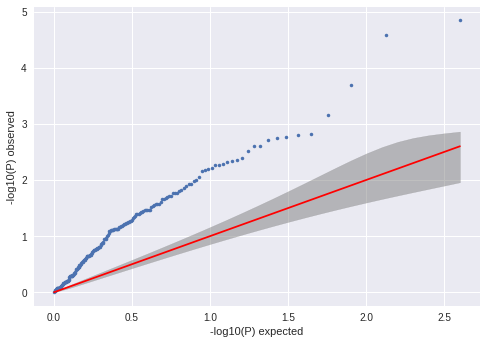

In [215]:
from limix.qtl import qtl_test_lmm
feature = 0
single_feature = filt_features[:,feature].copy()
res = qtl_test_lmm(single_feature, filt_expression.astype(float),covs=raw_technical_covariates)
pvalues = res.getPv()
from limix.plot import qqplot
lim_pvalues = res.getPv().flatten()
qqplot(lim_pvalues)
estimate_lambda(lim_pvalues)

Here we see a reduction in the $\lambda$ value, but not by much. It is also much high than 1.

## Including top 5 PCs as covariates

If we include the technical covariates in the model, we still see a high level of inflation. What about if we include the first 5 PCs?

2.52788983311


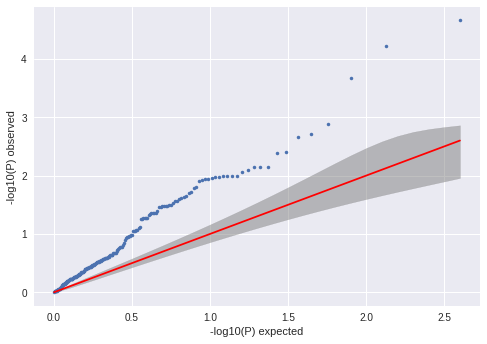

In [217]:
from sklearn.decomposition import PCA
from limix.plot import qqplot
from limix.qtl import qtl_test_lmm

k = 5
feature = 0
pca = PCA(n_components=k)
pca_transform = pca.fit_transform(filt_expression)
pca_transform.shape
test_cov = np.ones(shape=(274,k + 1))

test_cov[:,1:] = pca_transform

single_feature = filt_features[:,feature].copy()
res = qtl_test_lmm(single_feature, filt_expression.astype(float), covs=test_cov)
pvalues = res.getPv()

lim_pvalues = res.getPv().flatten()
lamb = estimate_lambda(lim_pvalues)
print (lamb)
qqplot(lim_pvalues)


This seems to account for some of the variation that exists.

What about for the first 15 PCs?

1.60345256528


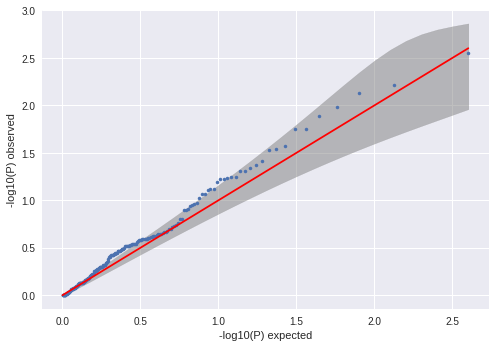

In [218]:
from sklearn.decomposition import PCA
from limix.plot import qqplot
from limix.qtl import qtl_test_lmm

k = 15
feature = 0
pca = PCA(n_components=k)
pca_transform = pca.fit_transform(filt_expression)
pca_transform.shape
test_cov = np.ones(shape=(274,k + 1))

test_cov[:,1:] = pca_transform

single_feature = filt_features[:,feature].copy()
res = qtl_test_lmm(single_feature, filt_expression.astype(float), covs=test_cov)
pvalues = res.getPv()

lim_pvalues = res.getPv().flatten()
lamb = estimate_lambda(lim_pvalues)
print (lamb)
qqplot(lim_pvalues)


This now seems to be removing all the noticable inflation including the signal.

How does the lambda value vary as a function of number of PCs we include?

In [219]:
from sklearn.decomposition import PCA
from limix.plot import qqplot
from limix.qtl import qtl_test_lmm

lambdas = []
for k in range(1,20):
    feature = 0
    pca = PCA(n_components=k)
    pca_transform = pca.fit_transform(filt_expression)
    pca_transform.shape
    test_cov = np.ones(shape=(274,k + 1))
    
    test_cov[:,1:] = pca_transform

    single_feature = filt_features[:,feature].copy()
    res = qtl_test_lmm(single_feature, filt_expression.astype(float), covs=test_cov)
    pvalues = res.getPv()

    lim_pvalues = res.getPv().flatten()
    lamb = estimate_lambda(lim_pvalues)
    lambdas.append(lamb)

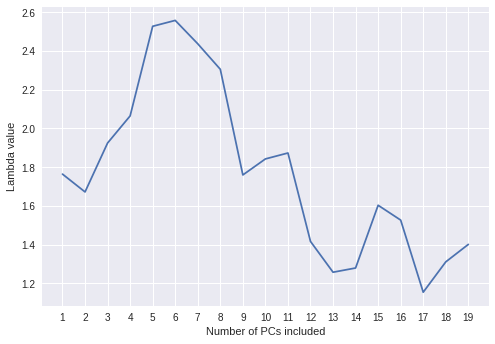

In [220]:
plt.plot(range(1,20),lambdas)
plt.xticks(range(1,20),range(1,20))
plt.xlabel("Number of PCs included")
plt.ylabel("Lambda value")
plt.show()

Interestingly, there seems to be a maximum at 5 PCs.

What about using the first two PCs?

1.67222500007


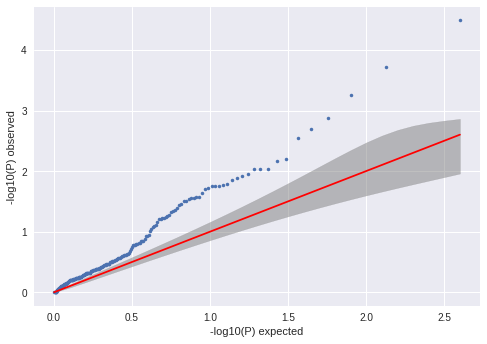

In [221]:
from sklearn.decomposition import PCA
from limix.plot import qqplot
from limix.qtl import qtl_test_lmm

k = 2
feature = 0
pca = PCA(n_components=k)
pca_transform = pca.fit_transform(filt_expression)
pca_transform.shape
test_cov = np.ones(shape=(274,k + 1))

test_cov[:,1:] = pca_transform

single_feature = filt_features[:,feature].copy()
res = qtl_test_lmm(single_feature, filt_expression.astype(float), covs=test_cov)
pvalues = res.getPv()

lim_pvalues = res.getPv().flatten()
lamb = estimate_lambda(lim_pvalues)
print (lamb)
qqplot(lim_pvalues)


This is a low value of $\lambda$, given the values of lambda that we have seen. But there is still are high level of overall inflation.

# Future directions

- Understand how limix deals with missing values:
- Experiment with including more technical factors as covariates.

Speaking with Danilo - it seems that limix does not incoorporate missing values automatically. It might be best to leave these samples out.